# Sparkify - Churn Prediction with PySpark


## 1. Introduction

### Business Context
Sparkify is a fictitious music streaming service, created by Udacity to mimic the datasets generated by companies such as Spotify or Pandora. Millions of users play their favorite songs through such services on a daily basis, either through free tier that plays advertisements, or by using a premium subscription model which offers additional functionalities and is typically ad-free. Users can upgrade or downgrade their subscription plan any time, but also cancel it altogether, so it is very important to make sure the users like the service. 

Every time a user interacts with a music streaming app, whether playing songs, adding them to playlists, rating them with the thumbs down/up, adding a friend, logging in or out, changing settings, data is generated. User activity logs contain key insights for helping the businesses understand whether the users are happy with the service.

In order to stay on track with its (financial) goals, it is key for a music streaming business to identify users that are likely to churn, i.e. users who are at risk of downgrading from premium to free tier, or cancelling the service. If a music streaming business accurately identifies such users in advance, they can offer them discounts or other similar incentives and save millions in revenues. It is a well-known fact that it is more expensive to acquire a new customer than it is to retain an existing one.

### Project Overview
Our goal is to build and train a binary classifier that is able to accurately identify users (in both free and paid tier) who cancelled the Sparkify music streaming service, based on the patterns obtained from their past activity and interaction with the service. A successfully trained model could be used to identify users who are likely to churn in advance.

The data used for training is the simulated Sparkify activity data provided by Udacity. The project is carried out by leveraging the Apache Spark distributed cluster-computing framework capabilities, through Python API for Spark, PySpark. The entire model development process (data understanding, feature engineering, model selection) is performed on a subset (1/100) of the full Sparkify dataset, by using Spark in local mode. Models that perform well on the smaller dataset are then trained and tested also on the full Sparkify dataset. Due to its size it cannot be processed locally and therefore an Elastic MapReduce (EMR) cluster has been deployed on the AWS cloud to carry out the tasks.

The project consists of three main steps that can be summarized as follows:

**Data Understanding**
- loading the dataset
- inferring the meaning of different variables, their type, the values they can take, their distribution
- understanding the relationships between different columns
- identifying missing values, potential duplicates

**Feature Engineering and Exploratory Data Analysis**
- transforming the original dataset (one row per user log) to a dataset with user-level (one row per user) information or statistics, obtained through mapping (e.g. user's gender, start/end of the observation period, etc.) or aggregation (e.g. song count, advertisement count, etc.) 
- engineering the features that will be used to identify churned users, e.g. aggregated statistic per unit of time, number of plan changes, songs played vs. total activity ratio, thumbs up vs. thumbs down ratio, activity trend, etc.
- defining and calculating the binary response variable: __1__ - users who cancelled their subscription within the observation period, and **0** - users who kept the service throughout
- analyzing the correlation between engineered features
- performing exploratory data analysis comparing the engineered statistics for users who stayed vs users who churned

**Modelling and Evaluation**
- defining pipelines that combine: standardization of the numerical features, feature assembly, and a selected binary classifier (logistic regression, random forest classifier or gradient boosting classifier)
- splitting the dataset into train and test set
- pipeline training and tuning using grid-search with cross validation for all different classifiers on the training data
- analyzing model performance in cross validation (using AUC as metric) and extracting feature importances
- retraining the models that performed best on the full training set and evaluating model performance on the test set (using standard AUC and F1 metrics)

**Note**: This notebook is used to perform the above-described steps on the smaller Sparkify dataset. Based on the research done and results obtained herein a subset of good performing models is selected, which are ultimately trained and tested also on the full 12GB Sparkify dataset. This is done by simply reusing the code developed herein and running it on an Amazon's EMR cluster. The corresponding results are reported in Section 5 below.

### Performance Metrics
Performance of the trained models is measured on the respective test set, by using standard metrics for measuring performance of binary classifiers, namely **AUC** and **F1** score. The justification of why they are considered appropriate for the given problem is provided in Section 4.4.

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [2]:
# Create a Spark Session
spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

In [3]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '34219'),
 ('spark.app.id', 'local-1566327652534'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'fe0cfcaac8c1')]

## 2. Data Understanding

Two sets of Sparkify user activity data have been provided for this project: a full 12GB dataset `sparkify_event_data.json`, and its smaller (128MB) subset `mini_sparkify_event_data.json`. We have used the latter for most of the data understanding steps, however, several queries have been run also on the full dataset to confirm the observed properties. 

### Data Description

As no documentation was provided alongside the provided datasets, we first had to perform a comprehensive data analysis in order to understand the data we are working with. 

According to the queries presented below, the dataset contains activity logs recorded between October 1, 2018 and November 30, 2018. The full dataset consists of approximately 26 million rows/logs, whereas the smaller subset contains 286500 rows. The full dataset collects logs of 22277 different users, whereas the subset only covers the activities of 225 users. Both datasets have 18 columns, as described below.

Every activity log belongs to a specific user. Seven columns in the dataset represent static user-level features (fixed for all logs belonging to a specific user):
- ___userId___ (string) : user identifier; 
- ___firstName___ (string) : user's first name
- ___lastName___ (string) : user's last name
- ___gender___ (string) : user's gender; 2 categories (*M* and _F_)
- ___location___ (string) : user's location
- ___userAgent___ (string) : agent used by the user to access streaming service; 57 different categories
- ___registration___ (bigint) : user's registration timestamp

One other user-level feature, non-static however, is the user's subscription level at the time when log was recorded:
- ___level___ (string) : subscription level; 2 categories (_free_ and _paid_)

Most important for this project are columns with log-specific information, as they provide insights into how different users interact with the music streaming service:
- ___ts___ (bigint) : timestamp of a given log  
- ___page___ (string): type of interaction (page accessed in the music streaming app); 22 categories (_NextSong_, _Home_, _Login_, _Cancellation Confirmation_, etc.)
- ___auth___ (string) : authentication level; 4 categories (_Logged In_, _Logged Out_, _Cancelled_, _Guest_)
- ___sessionId___ (bigint) : session to which the log belongs to
- ___itemInSession___ ('bigint') : log count in a given session
- ___method___ (string) : http request method; 2 categories (_GET_ and _PUT_)
- ___status___ (bigint) : http status code; 3 categories (_200_, _307_ and _404_)

The dataset includes also three other columns representing song-level features. These are relevant only for logs in which a song was played (corresponding to _NextSong_ interaction type):
- ___song___ (string) : song name
- ___artist___ (string) : artist name
- ___length___ (double) : song's length in seconds

### Notes & Observations
By analyzing the different columns, as well as their relationships, we have made the following additional observations about the imported dataset:
- there are no duplicate logs in the provided dataset
- all the rows with missing values in the ***userId*** column (and all other user-level features) correspond to logs in which no user has been logged in (_Logged Out_ and _Guest_ authentication levels)
- _Cancelled_ authentication level corresponds directly to _Cancellation Confirmation_ activity type in the ***page*** column
- there are no missing ***sessionId*** values
- ***sessionId*** uniquely identifies a session only within activity logs of a specific user (i.e. specific sessionID can be used to label sessions of multiple different users) 
- maximum time interval between two consecutive logs that still belong to the same session is one hour
- song-level features ***song***, ***artist*** and ***length*** have non-missing values only for _NextSong_ interaction type (shown in the ***page*** column)
- there are some artist-song name pairs in the dataset that have non-unique song lengths (might be due to re-releases)
- http ***method*** and ***status*** are essentially mappings/groupings of the categories in the ***page*** variable (e.g. status _404_ directly corresponds to _Error_ value in the page column)

### Data Analysis

In [4]:
# Load data and store it into a Spark dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [5]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Column types 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [7]:
# Shape of the smaller Sparkify dataframe
nrows = df.count()
ncols = len(df.dtypes)
print(f'The imported dataframe has {nrows} rows and {ncols} columns.')

The imported dataframe has 286500 rows and 18 columns.


In [8]:
# Potential duplicate entries
df.count() - df.dropDuplicates().count()

0

In [9]:
# Print first 5 rows to get the idea of the dataframe; first 11 columns in alphabetical order
df.select(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
           'length', 'level', 'location', 'method', 'page']).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|
+----------------+------

In [10]:
# Print first 5 rows to get the idea of the dataframe; 12.-18. column
df.select(['registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']).show(5)


+-------------+---------+--------------------+------+-------------+--------------------+------+
| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+--------------------+------+-------------+--------------------+------+
|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [11]:
# Logs belonging to a specific user
df.where(df.userId == 4).select(['userId','sessionId','itemInSession','auth','level','page','ts']).show(500)

+------+---------+-------------+---------+-----+---------------+-------------+
|userId|sessionId|itemInSession|     auth|level|           page|           ts|
+------+---------+-------------+---------+-----+---------------+-------------+
|     4|      240|            0|Logged In| free|       NextSong|1538356650000|
|     4|      240|            1|Logged In| free|         Logout|1538356651000|
|     4|      240|            4|Logged In| free|           Home|1538356686000|
|     4|      240|            5|Logged In| free|       NextSong|1538356889000|
|     4|      240|            6|Logged In| free|           Home|1538356954000|
|     4|      240|            7|Logged In| free|       NextSong|1538357110000|
|     4|      240|            8|Logged In| free|       NextSong|1538357328000|
|     4|      240|            9|Logged In| free|       NextSong|1538357543000|
|     4|      240|           10|Logged In| free|       NextSong|1538357746000|
|     4|      240|           11|Logged In| free|    

In [12]:
# Convert the timestamps in columns 'registration' and 'ts' into datetime format and add them to the dataframe
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [13]:
# Obtain start of the observation period

# Based on the data shown below it seems the observation period started at 00:00:01, October 1, 2018
df.select('userId', 'page', 'ts', 'tsDate').sort('ts').show(10)

+------+---------------+-------------+-------------------+
|userId|           page|           ts|             tsDate|
+------+---------------+-------------+-------------------+
|    30|       NextSong|1538352117000|2018-10-01 00:01:57|
|     9|       NextSong|1538352180000|2018-10-01 00:03:00|
|    30|       NextSong|1538352394000|2018-10-01 00:06:34|
|     9|       NextSong|1538352416000|2018-10-01 00:06:56|
|    30|       NextSong|1538352676000|2018-10-01 00:11:16|
|     9|       NextSong|1538352678000|2018-10-01 00:11:18|
|     9|       NextSong|1538352886000|2018-10-01 00:14:46|
|    30|       NextSong|1538352899000|2018-10-01 00:14:59|
|    30|Add to Playlist|1538352905000|2018-10-01 00:15:05|
|    30|       NextSong|1538353084000|2018-10-01 00:18:04|
+------+---------------+-------------+-------------------+
only showing top 10 rows



In [14]:
# Obtain end of the observation period

# Based on the data shown below it seems the observation period ended at 23:59:59, November 30, 2018 
# There seem to be 3 corrupted entries that fall after the cutoff - particularly strange is the very last log 
# in the dataset that seems to be recorded two full days after the penultimate one. This minor issue will be handled
# in the data preparation part.
df.select('userId', 'page', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

+------+---------------+-------------+-------------------+
|userId|           page|           ts|             tsDate|
+------+---------------+-------------+-------------------+
|100002|       NextSong|1543799476000|2018-12-03 01:11:16|
|200008|       NextSong|1543622579000|2018-12-01 00:02:59|
|   152|       NextSong|1543622432000|2018-12-01 00:00:32|
|300011|       NextSong|1543622411000|2018-12-01 00:00:11|
|300011|          About|1543622398000|2018-11-30 23:59:58|
|200008|       NextSong|1543622395000|2018-11-30 23:59:55|
|   138|       NextSong|1543622365000|2018-11-30 23:59:25|
|    39|       NextSong|1543622355000|2018-11-30 23:59:15|
|    30|Add to Playlist|1543622320000|2018-11-30 23:58:40|
|    30|       NextSong|1543622287000|2018-11-30 23:58:07|
+------+---------------+-------------+-------------------+
only showing top 10 rows



#### User-level features

In [15]:
# Obtain the number of distinct users in the smaller Sparkify dataset
# (In the full Sparkify dataset there is 22277 unique users)
df.select(['userId']).dropDuplicates().count()

226

In [16]:
# Explore missing values in the 'userId' column
df.where(df.userId.isNull()).count()

0

In [17]:
# Print 'userId' values:
df.select(['userId']).dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [18]:
# There are rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

8346

In [19]:
# Rows with empty string in the 'userId' column correspond to logs in which user has not been logged in
# (either 'Logged Out' or 'Guest' authentication levels). By looking at the sessionId one could potentially still 
# obtain the userId to which the rows with auth='Logged Out' belong, nevertheless, such rows do not contain
# key information about user activity, so they can simply be deleted in the data preparation step.

df.select(['userId','firstName','gender','lastName',
           'sessionId','location','auth','level','ts','page']).where(df.userId == "").show(10)

df.where(df.userId == "").groupby('auth').count().show()

+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|userId|firstName|gender|lastName|sessionId|location|      auth|level|           ts| page|
+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355745000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355807000| Help|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355841000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355842000|Login|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356678000| Home|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356679000|Login|
|      |     null|  null|    null|      100|    null|Logged Out| free|1538358102000|Login|
|      |     null|  null|    null|      241|    null|Logged Out| free|1538360117000|Login|

In [20]:
# User-level information is consistent in all the logs in the dataset. If this was not the case, 
# drop duplicates method would identify inconsistent number of unique users.
df.select(['firstName','gender','lastName','location','registration','userAgent','userId']) \
.where(df.userId != "") \
.dropDuplicates().count()

225

In [21]:
# Out of the static user-level features it is probably most interesting to analyze the 'gender' distribution...

# ...in the list of unique users
gender_dist = df.select(['userId','gender'])\
.where(df.userId != "") \
.dropDuplicates(['userId']).groupby('gender').count().toPandas()

gender_dist_rel = (gender_dist.set_index('gender') / sum(gender_dist['count']))

# ...in the activity dataset
gender_dist_logs = df.where(df.userId != "").groupby('gender').count().toPandas()

gender_dist_logs_rel = (gender_dist_logs.set_index('gender') / sum(gender_dist_logs['count']))

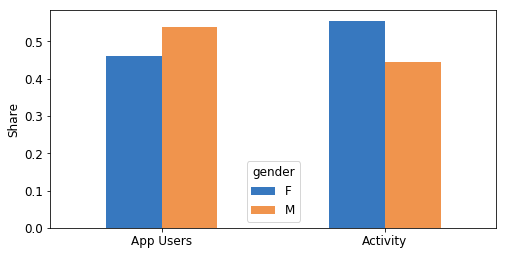

In [22]:
# It is interesting to see that while there is more male users in the analyzed dataset (Sparkify subset),
# there is a considerably higher share of logs coming from the female population
comparison = gender_dist_rel.merge(gender_dist_logs_rel, on='gender')
comparison.columns = ['App Users', 'Activity']

# Define plotting parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 12})

# Define colors to use throughout this notebook
colors = ["windows blue", "faded orange"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]

# Plot
comparison.transpose().plot.bar(rot = 0, color = [color1, color2]);
plt.ylabel('Share');
plt.savefig('gender')

In [23]:
# The subscription 'level' variable is rather indepdendent of other variables in the dataset. The users can switch between 
# free and paid tier anytime, hence the variable is, unlike other user-level features, not fixed throughout the entire
# observation period.
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [24]:
# We can analyze for each user how many interactions he/she had under the free plan relative to all interactions
# in both free and paid plan. From the histogram below we can see that the majority of users seems to stick to their 
# subscription plan, as more than 40 users (out of 225) interacted with the service mostly using the premium service, 
# and around 60 stayed in the free tier throughout the entire observation period.

tier_analysis = df.where(df.userId != '')\
.groupby(['userId'])\
.agg(Fsum(when(col('level') == 'free',1).otherwise(0)).alias('freelogs'),
     Fsum(when(col('level')=='paid',1).otherwise(0)).alias('paidlogs'))

tier_analysis = tier_analysis.withColumn('shareoffree', col('freelogs') / (col('freelogs') + col('paidlogs')))
tier_analysis_pd = tier_analysis.toPandas()

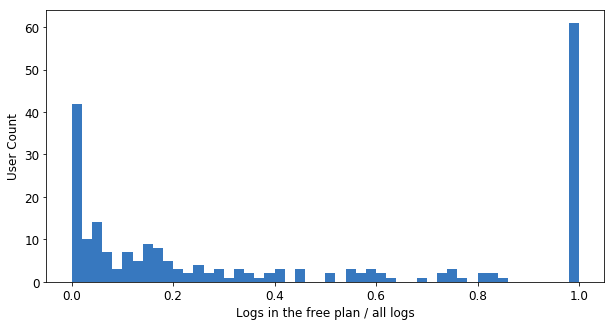

In [25]:
# Plot
plt.rcParams['figure.figsize'] = (10,5)
tier_analysis_pd['shareoffree'].plot.hist(bins = 50,  color = color1);
plt.ylabel('User Count');
plt.xlabel('Logs in the free plan / all logs');
plt.savefig('subscriptionchange')

#### Log-specific features

In [26]:
# Explore the 'page' column that represents the types of interactions with the music streaming service

# There are no missing values in the 'page' column
df.where(df.page.isNull()).count()

0

In [27]:
# Obtain the distribution of the interaction types in the analyzed dataset
df.groupby('page').count().sort('count', ascending = False).show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



In [28]:
# The smaller dataset is representative - distribution of the interaction types is similar in the full Sparkify dataset
# COPIED FROM notebook used on the CLUSTER
page_pd_full = pd.DataFrame({'page' : ['NextSong','Home','Thumbs Up', 'Add to Playlist', 'Roll Advert', 'Add Friend', 
                                       'Login','Logout', 'Thumbs Down', 'Downgrade', 'Help', 'Settings', 'About', 
                                       'Upgrade', 'Save Settings', 'Error', 'Submit Upgrade', 'Submit Downgrade', 'Cancel',
                                     'Cancellation Confirmation', 'Register', 'Submit Registration'],
                             'count' : [20850272, 1343102, 1151465, 597921, 385212, 381664, 296350, 296005, 239212,
                                    184240, 155100, 147074, 92759, 50507, 29516, 25962, 15135, 6494, 5003, 5003, 802,401]})

page_pd_full['Full Sparkify Dataset'] = page_pd_full['count'] / sum(page_pd_full['count'])

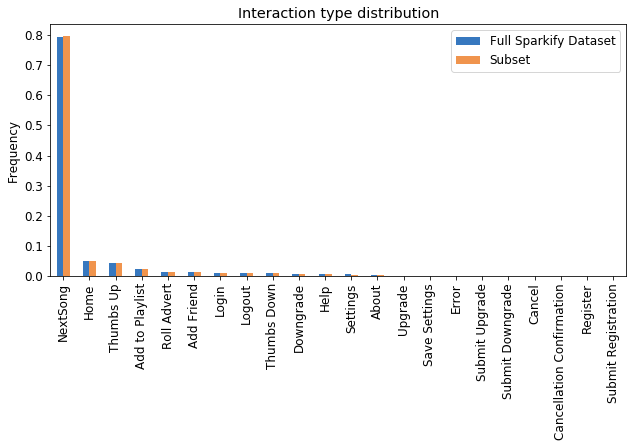

In [29]:
# Visualize the categorical distribution
page_pd = df.groupby('page').count().sort('count', ascending = False).toPandas()
page_pd['Subset'] = page_pd['count'] / sum(page_pd['count'])
# Compare to statistics calculated on gull Sparkify dataset
compare_pd = page_pd_full.merge(page_pd, on = 'page')

# Plot
plt.rcParams['figure.figsize'] = (10,7)
compare_pd.plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",  color = [color1, color2]);
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype1');

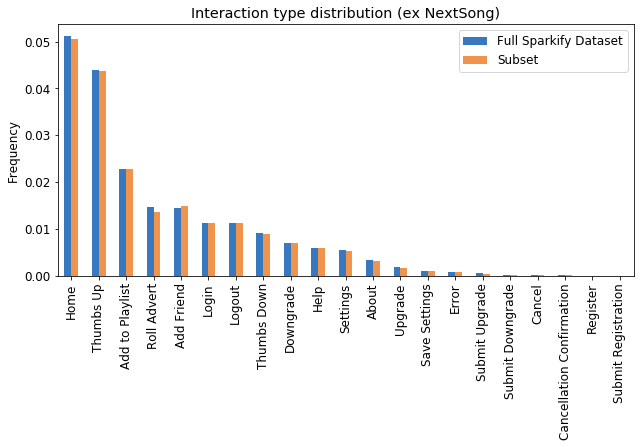

In [30]:
# Distribution ex playing songs
compare_pd[compare_pd['page']!='NextSong'].plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",
                                               color = [color1, color2]);

# Plot
plt.rcParams['figure.figsize'] = (10,7)
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution (ex NextSong)");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype2')

In [31]:
# Explore the auth column
df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [32]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column
df.where(df.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

+------+-------------------+---------+---------+--------------------+
|userId|             tsDate|sessionId|     auth|                page|
+------+-------------------+---------+---------+--------------------+
|    18|2018-10-07 20:26:30|      514|Cancelled|Cancellation Conf...|
|    32|2018-10-08 21:10:46|      540|Cancelled|Cancellation Conf...|
|   125|2018-10-12 04:35:18|      174|Cancelled|Cancellation Conf...|
|   105|2018-10-12 20:17:21|      508|Cancelled|Cancellation Conf...|
|    17|2018-10-13 21:19:44|      797|Cancelled|Cancellation Conf...|
+------+-------------------+---------+---------+--------------------+
only showing top 5 rows



In [33]:
# Explore sessionId
df.select('sessionId').dropDuplicates().count()

2354

In [34]:
# There are no missing values in the sessionId column
df.where(df.sessionId.isNull()).count()

0

In [35]:
# There are also no empty strings in the column
df.where(df.sessionId == "").count()

0

In [36]:
#SessionId is a unique identifier only for a specific user. Multiple users can have sessions labelled with the
#same sessionId
df.where(df.userId != "")\
.select(['userId','sessionId']).dropDuplicates()\
.groupby('sessionId').count().sort('count', ascending = False).show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|      113|    4|
|      112|    4|
|      167|    4|
|       65|    4|
|       54|    4|
+---------+-----+
only showing top 5 rows



In [37]:
# Example of the same sessionId for sessions of multiple users
df.where((df.userId != "") & (df.sessionId == 113))\
.select(['userId','sessionId','itemInSession','auth','level','page','tsDate']).show(500)

+------+---------+-------------+---------+-----+---------------+-------------------+
|userId|sessionId|itemInSession|     auth|level|           page|             tsDate|
+------+---------+-------------+---------+-----+---------------+-------------------+
|   114|      113|            0|Logged In| free|           Home|2018-10-03 18:05:47|
|   114|      113|            1|Logged In| free|       NextSong|2018-10-03 18:05:52|
|   114|      113|            2|Logged In| free|       NextSong|2018-10-03 18:08:45|
|   114|      113|            3|Logged In| free|       NextSong|2018-10-03 18:13:43|
|   114|      113|            4|Logged In| free|       NextSong|2018-10-03 18:18:46|
|   114|      113|            5|Logged In| free|       NextSong|2018-10-03 18:23:15|
|   114|      113|            6|Logged In| free|           Home|2018-10-03 18:23:25|
|   114|      113|            7|Logged In| free|       NextSong|2018-10-03 18:27:05|
|   114|      113|            8|Logged In| free|       NextSong|2

In [38]:
# Sessions in the dataset can be very long. The longest lasted 267305 seconds which is more than 74 hours.
session_end = df.where(df.userId != "") \
.groupby(['userId','sessionId']).agg(Fmax('ts').alias('max'), 
                                     Fmin('ts').alias('min'), 
                                     ((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
.sort('sessionlength', ascending = False).show(5)

+------+---------+-------------+-------------+-------------+
|userId|sessionId|          max|          min|sessionlength|
+------+---------+-------------+-------------+-------------+
|    91|     1840|1542852334000|1542585029000|     267305.0|
|   115|      316|1538924417000|1538701498000|     222919.0|
|   101|      635|1539263366000|1539065365000|     198001.0|
|   120|      731|1539793336000|1539630700000|     162636.0|
|    61|      529|1539247693000|1539096212000|     151481.0|
+------+---------+-------------+-------------+-------------+
only showing top 5 rows



In [39]:
# Based on the analysis performed it seems that the maximum time between two consecutive logs that still belong to 
# the same sesssion is one hour. In the provided dataset the maximum interval is 3310 seconds which is around 55 minutes.
windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
df = df.withColumn("diff", (df.ts - df.previousts)/1000)
df.where(df.userId != "").agg(Fmax(col('diff'))).show()

+---------+
|max(diff)|
+---------+
|   3310.0|
+---------+



In [40]:
# Http request method categories PUT and GET can be seen as two groupings of categories in the 'page' column
df.groupby(['method','page']).count().sort('method').show(22)

+------+--------------------+------+
|method|                page| count|
+------+--------------------+------+
|   GET|               Error|   258|
|   GET|                Help|  1726|
|   GET|            Settings|  1514|
|   GET|                Home| 14457|
|   GET|Cancellation Conf...|    52|
|   GET|            Register|    18|
|   GET|           Downgrade|  2055|
|   GET|         Roll Advert|  3933|
|   GET|               About|   924|
|   GET|             Upgrade|   499|
|   PUT|              Cancel|    52|
|   PUT|              Logout|  3226|
|   PUT|     Add to Playlist|  6526|
|   PUT|          Add Friend|  4277|
|   PUT| Submit Registration|     5|
|   PUT|      Submit Upgrade|   159|
|   PUT|           Thumbs Up| 12551|
|   PUT|    Submit Downgrade|    63|
|   PUT|               Login|  3241|
|   PUT|            NextSong|228108|
|   PUT|         Thumbs Down|  2546|
|   PUT|       Save Settings|   310|
+------+--------------------+------+



In [41]:
# Similar holds also for the http status code 
df.groupby(['status','page']).count().sort('status').show(22)

+------+--------------------+------+
|status|                page| count|
+------+--------------------+------+
|   200|             Upgrade|   499|
|   200|     Add to Playlist|  6526|
|   200|Cancellation Conf...|    52|
|   200|            NextSong|228108|
|   200|         Roll Advert|  3933|
|   200|            Register|    18|
|   200|                Help|  1726|
|   200|            Settings|  1514|
|   200|               About|   924|
|   200|           Downgrade|  2055|
|   200|                Home| 14457|
|   307|           Thumbs Up| 12551|
|   307|              Logout|  3226|
|   307|         Thumbs Down|  2546|
|   307|               Login|  3241|
|   307|    Submit Downgrade|    63|
|   307|       Save Settings|   310|
|   307|              Cancel|    52|
|   307|      Submit Upgrade|   159|
|   307|          Add Friend|  4277|
|   307| Submit Registration|     5|
|   404|               Error|   258|
+------+--------------------+------+



##### Song-level features

In [42]:
# Song-level features have obviously non-missing values only for the page='NextSong' activity logs
df.where(df.artist.isNotNull()).groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [43]:
# Number of different artists
df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()

17655

In [44]:
# Number of different song names
df.where(df.song.isNotNull()).select('song').dropDuplicates().count()

58480

In [45]:
# There are some artist-song name pairs in the dataset that have non-unique song lengths. This might be due to the fact 
# that some songs with the same name (and artist name) are released multiple times.
df.select(['artist','song','length']).dropDuplicates().count()

65966

In [46]:
df.select(['artist','song']).dropDuplicates().count()

65417

## 3. Feature Engineering and Exploratory Data Analysis

As mentioned earlier, the goal of this project is to build and train a supervised machine learning model that would be able to accurately identify users who cancelled the music streaming service, based on the patterns in their interaction with the service. Since both the predictors and the response variable need to be defined at the level of an individual user, we had to first transform the original dataset (one row per log) to a dataset with user-level information or statistics (one row per user), obtained either through mapping (e.g. user's gender, length of observation period, etc.) or aggregation (e.g. activity count). We have then further transformed this information to engineer the exact features that are used in the model, and also to define the binary response variable.

After completing the feature engineering step we have analyzed the correlations between the built features, and performed also a brief exploratory data analysis with visualizations to inspect how the features relate to the binary response.

### 3.1 Transformations on the Original Dataset

#### 3.1.1 User-specific observation period

Most of the features constructed in the later steps are aggregated statistics per unit of time, and in order to calculate them we had to first obtain the exact observation period that applies to each user. The original dataset includes logs recorded between October 1, 2018 and November 30, 2018, but for some users the observation period is shorter. There are users in the dataset who registered later than October 1, and some individuals who cancelled the service before the end of the observation period, the so-called churned users.

**Note:** One of the ideas was to include in the set of features also user's activity trend, therefore some additional data wrangling had to be done on the original dataset (one row per log). Specifically, in order to estimate aggregate statistics in different periods of the observation window we had to calculate the relative timing of each log versus the start and end of the respective observation period. For this reason, also some user-level statistics (e.g. observation start/end that is fixed for all logs from a specific user) have been calculated on the original dataset.

In [47]:
# Default observation start and end timestamps for users who have registered before October 1 and haven't churned
obs_start_default = 1538352000000
obs_end_default = 1543622400000

###### Registration
To recall, user's registration dates are listed in the _registration_ column of the imported dataset, but we have observed that they do not always seem to be correct. For users who registered after the start of the default observation period the registration dates are not consistent with the actual log timestamps and activity types. We thus had to obtain late registrations by finding 'Submit Registration' logs in the _page_ column. This step is not trivial as such log events are not mapped to any _userId_ so those had to be extracted from the _sessionId_ information.

In [48]:
# User registrations after the start of the observation period, according to the values in the 'registration' column
df.where(df.registration > obs_start_default).select(['userId','registrationDate']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationDate|
+------+-------------------+
|   156|2018-11-26 15:49:14|
|   153|2018-11-03 05:42:17|
|   154|2018-11-03 18:00:21|
|   155|2018-11-04 22:27:50|
|   152|2018-10-30 23:03:28|
+------+-------------------+



In [49]:
# "Submit registration" events have empty strings in the userId column.
# The userId can be inferred from the sessionId information.
df.select(['userId','auth','page','tsDate','sessionId']).where(df.page == 'Submit Registration').show()

+------+-----+-------------------+-------------------+---------+
|userId| auth|               page|             tsDate|sessionId|
+------+-----+-------------------+-------------------+---------+
|      |Guest|Submit Registration|2018-10-30 06:59:07|     1402|
|      |Guest|Submit Registration|2018-11-02 15:13:19|     1506|
|      |Guest|Submit Registration|2018-11-02 15:55:56|      154|
|      |Guest|Submit Registration|2018-11-08 21:10:33|     1719|
|      |Guest|Submit Registration|2018-11-26 23:12:49|     2288|
+------+-----+-------------------+-------------------+---------+



In [50]:
# Registration of the userId=154 - note that the time of "Submit Registration" log does not match the 
# registration time printed above.
df.select(['userId','auth','page','tsDate', 'sessionId']).where(df.sessionId == 1506).show(10)

+------+---------+-------------------+-------------------+---------+
|userId|     auth|               page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|      |    Guest|               Home|2018-11-02 15:12:56|     1506|
|      |    Guest|           Register|2018-11-02 15:13:18|     1506|
|      |    Guest|Submit Registration|2018-11-02 15:13:19|     1506|
|   154|Logged In|               Home|2018-11-02 15:15:35|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:15:38|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:18:39|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:22:19|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:26:59|     1506|
|   154|Logged In|           NextSong|2018-11-02 15:32:26|     1506|
|   154|Logged In|        Roll Advert|2018-11-02 15:33:03|     1506|
+------+---------+-------------------+-------------------+---------+
only showing top 10 rows



As can be seen in the table above, the 'Submit Registration' event is followed by user's first interaction in the same session. To identify users with late registrations we have shifted the _page_ column by one index (within a given session) and checked whether the first entry of the lagged column reads 'Submit Registration'. For each such user the start of the observation period has been set to the timestamp of his/her first log, whereas for all other users the default start time applies.

In [51]:
# Lag the page column
windowsession = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn("lagged_page", lag(df.page).over(windowsession))

In [52]:
# With the lagged page column we can identify the users that registered later
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate', 'sessionId']).show()

+------+---------+-------------------+-------------------+---------+
|userId|     auth|        lagged_page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|   156|Logged In|Submit Registration|2018-11-26 23:14:00|     2288|
|   154|Logged In|Submit Registration|2018-11-02 15:15:35|     1506|
|   152|Logged In|Submit Registration|2018-10-30 06:59:09|     1402|
|   155|Logged In|Submit Registration|2018-11-02 15:56:25|      154|
|   153|Logged In|Submit Registration|2018-11-08 21:11:10|     1719|
+------+---------+-------------------+-------------------+---------+



In [53]:
# All the values calculated here are the same for all logs belonging to a given user. Nevertheless, we attach them to the
# original dataset, as they are needed for activity trend calculation 
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Identify users that registered after the start of observation, and infer the start date accordingly
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", 
                   when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

In [54]:
# Alternative approach: using directly the registration dates in the 'registration' column
# df = df.withColumn("obsstart", when(df.registration > obs_start_default, df.registration).otherwise(obs_start_default))

##### Cancellation
Similar to above, there are users who cancelled their service before the end of the default observation period, the so-called churned users. One can simply identify them by finding all the 'Cancellation Confirmation' entries in the _page_ column. For each such user the end of the respective observation period has been set to the timestamp of his/her last log entry, whereas for all other users the default end date applies.

In [55]:
# Identify users that cancelled their service, i.e. users whose last log event is "Cancellation Confirmation", and
# obtain the corresponding end of the observation period. This is done on the original dataset
# so a single value, e.g. end of observation period, is copied to all rows belonging to a given userId.

df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))

##### Relative timing of each log
As mentioned before, we wanted to include activity trend as one of the predictors of churned users. Trend can be estimated by calculating a specific metric on the first and last _k_ days of the observation period and then comparing them. For this specific purpose, we had to first calculate the timing of each log relative to the start and end of the respective user-specific observation period. 

In [56]:
# For each log compute the time from the beginning of observation...
df = df.withColumn("timefromstart", col('ts')-col("obsstart"))
# ...and time before the end of observation
df = df.withColumn("timebeforeend", col('obsend')-col('ts'))

In [57]:
# Example of a user with default observation start and earlier observation end due to Cancellation Confirmation
df.select(['userId','obsstart','obsend','endstate','page','ts','timefromstart','timebeforeend'])\
.where(df.userId == 100023).show(5)

+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|            endstate|      page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|100023|1538352000000|1539475237000|Cancellation Conf...|     About|1538665362000|    313362000|    809875000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538665432000|    313432000|    809805000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665433000|    313433000|    809804000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665434000|    313434000|    809803000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538767734000|    415734000|    707503000|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
o

In [58]:
# Example of a user with later observation start due to Submit Registration activity, and default end date
df.select(['userId','obsstart','obsend','beforefirstlog','page','ts','timefromstart','timebeforeend'])\
.where(df.userId == 154).show(5)

+------+-------------+-------------+-------------------+--------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|     beforefirstlog|    page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+-------------------+--------+-------------+-------------+-------------+
|   154|1541171735000|1543622400000|Submit Registration|    Home|1541171735000|            0|   2450665000|
|   154|1541171735000|1543622400000|Submit Registration|NextSong|1541171738000|         3000|   2450662000|
|   154|1541171735000|1543622400000|Submit Registration|NextSong|1541171919000|       184000|   2450481000|
|   154|1541171735000|1543622400000|Submit Registration|NextSong|1541172139000|       404000|   2450261000|
|   154|1541171735000|1543622400000|Submit Registration|NextSong|1541172419000|       684000|   2449981000|
+------+-------------+-------------+-------------------+--------+-------------+-------------+-------------+
only showing top 5 rows



In [59]:
# Alternative approch: the observation period lasts from first to last log 
#windowval = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
#df = df.withColumn("lastdate",last(col('ts')).over(windowval))
#df = df.withColumn("firstdate",first(col('ts')).over(windowval))
#df = df.withColumn("difftolast", col('lastdate')-col('ts'))
#df = df.withColumn("difftofirst", col('ts')-col('firstdate'))
#df.select(['userId','page','lastdate','firstdate','difftolast','difftofirst']).show(500)

#### 3.1.2 Last Subscription Level
One other operation that we have performed on the original dataset is finding the user's last subscription _level_ (free or paid) at the last log entry, so either user's subscription level at the time of cancellation, or at the end of the default observation period. As described later in the notebook, the last subscription level has actually been used as one of the features in the churn prediction model.

**Note**: This operation has been performed on the original dataset (and not in the mapping/aggregation step) simply to prevent potential data order issues when using Spark's _groupby_ together with _last_ aggregator.

In [60]:
# Obtain user's last subscription level and add it to the original dataset
df = df.withColumn("lastlevel", last(col('level')).over(windowuser))

#### 3.1.3 Removing rows with no userId information
After obtaining the user-specific observation periods we have deleted the rows with empty strings in the _userId_ column, as such entries do not contain insights that could help us predict churned users.

In [61]:
# Remove rows with missing userId 
df = df.where(df.userId != "")
df.count()

278154

#### 3.1.4 Removing rows with timestamps beyond the inferred default observation period
As mentioned in the data analysis step, it seems the imported dataset also includes some corrupted log entries with timestamps well beyond the typical default observation period. Such rows are extremely rare, but it is worth removing them anyway.

In [62]:
# Remove rows with corrupted timestamps
df = df.where(df.ts < obs_end_default)
df.count()

278150

### 3.2 Mapping and Aggregation

As the next step, we have transformed the original Sparkify dataset (one row per log) to a dataset with user-level information or statistics (one row per user), which have been obtained either through mapping from the original dataset (applies to user-level features such as user's gender, last subscription level, etc.) or aggregation (grouping the logs by userId, e.g. total activity count of each user). 

The newly created dataset includes the following columns:
- ***userId***
- ***lastlevel*** : user's last subscription level, transformed into binary format (1 - paid tier, 0 - free tier)
- ***gender*** : gender, transformed into binary format (1 - female, 0 - male)
- ***obsstart, obsend***: start and end of the observation period
- ***endstate*** : last interaction in the observation period
- ***nact*** : user's total number of interactions in the observation period
- ***nsongs, ntbup, ntbdown, nfriend, nplaylist, ndgrade, nupgrade, nhome, nadvert, nhelp, nsettings, nerror*** : number of songs played, thumbs up given, thumbs down given, friends added, songs added to playlist, downgrades, upgrades, home page visits, advertisements played, help page visits, settings visits, errors, respectively
- ***nact_recent, nact_oldest*** : user's activity in the last and first _k_ days of the observation window, respectively
- ***nsongs_recent, nsongs_oldest*** : songs played in the last and first _k_ days of the observation window, respectively

In [63]:
# Length of the estimation window for activity trend calculation
trend_est_days = 14
trend_est_hours = trend_est_days * 24
# In timestamp format
trend_est = trend_est_days * 24 * 60 * 60 * 1000

In [64]:
# Aggregation by userId
df_user = df.groupby('userId')\
.agg(
     # User-level features
     first(when(col('lastlevel') == 'paid', 1).otherwise(0)).alias('lastlevel'),
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     first(col('obsstart')).alias('obsstart'),
     first(col('obsend')).alias('obsend'),
     first(col('endstate')).alias('endstate'),
     #first(col('location')).alias('location'),
     #first(col('userAgent')).alias('userAgent')
     #first(col('registration')).alias('registration'),
     
     # Aggregated activity statistics
     count(col('page')).alias('nact'),
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsongs"),
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("nsettings"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror"),
     
     # Aggregated activity statistics in different periods 
     Fsum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias("nact_recent"),
     Fsum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias("nact_oldest"),
     Fsum(when((col('page') == "NextSong") & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias("nsongs_recent"),
     Fsum(when((col('page') == "NextSong") & (col('timefromstart') < trend_est), 1).otherwise(0)).alias("nsongs_oldest") )

In [65]:
# Sample rows in a newly created dataset; user-level features
df_user.select(['userId','gender','lastlevel','obsstart','obsend','endstate']).show(5)

+------+------+---------+-------------+-------------+--------------------+
|userId|gender|lastlevel|     obsstart|       obsend|            endstate|
+------+------+---------+-------------+-------------+--------------------+
|100010|     1|        0|1538352000000|1543622400000|              Logout|
|200002|     0|        1|1538352000000|1543622400000|           Thumbs Up|
|   125|     0|        0|1538352000000|1539318918000|Cancellation Conf...|
|   124|     1|        1|1538352000000|1543622400000|                Home|
|    51|     0|        1|1538352000000|1539761972000|Cancellation Conf...|
+------+------+---------+-------------+-------------+--------------------+
only showing top 5 rows



In [66]:
# Sample rows in a newly created dataset; aggregated activity statistics
df_user.select(['userId','nact','nsongs','ntbup','ntbdown','nfriend','nplaylist',
                'ndgrade','nugrade','nhome','nadvert','nhelp','nsettings','nerror']).show(5)

+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|userId|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nsettings|nerror|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|100010| 381|   275|   17|      5|      4|        7|      0|      0|   11|     52|    2|        0|     0|
|200002| 474|   387|   21|      6|      4|        8|      0|      1|   20|      7|    2|        3|     0|
|   125|  11|     8|    0|      0|      0|        0|      0|      0|    0|      1|    0|        0|     0|
|    51|2464|  2111|  100|     21|     28|       52|      0|      0|   75|      0|   12|       12|     1|
|   124|4825|  4079|  171|     41|     74|      118|      0|      0|  176|      4|   23|       20|     6|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
only showing top 5 rows



In [67]:
# Sample rows in a newly created dataset; aggregated activity statistics in different periods
df_user.select(['userId','nact_recent','nact_oldest','nsongs_recent','nsongs_oldest']).show(5)

+------+-----------+-----------+-------------+-------------+
|userId|nact_recent|nact_oldest|nsongs_recent|nsongs_oldest|
+------+-----------+-----------+-------------+-------------+
|100010|         33|         40|           24|           31|
|200002|          0|         37|            0|           24|
|   125|         11|         11|            8|            8|
|   124|        509|       1093|          440|          921|
|    51|       1865|       2052|         1614|         1757|
+------+-----------+-----------+-------------+-------------+
only showing top 5 rows



### 3.3. Feature Engineering
By using the mappings and aggregated statistics expressed at the level of an individual user we could then finally construct the features that in our opinion contain key insights for identifying churned users. 

**Note**: When defining predictor variables one needs to make sure that they do not contain any information that would not be available if running a model on an unlabelled dataset. For example, in the original log dataset churned users typically have significantly shorter observation periods, therefore, total activity count would not be an appropriate predictor, as it contains indirect information about the response variable, which we would not have if the data was unlabelled. For this reason, all the features need to be expressed either per unit of time or in relation to another variable measured over the same observation period. However, since the relative statistics for different users are measured on sometimes inconsistent observation periods, one needs to assume that the underlying data distributions in the 2-month window do not change due to some exogenous variable (but only due to the users themselves - which is measured in the activity trend feature defined below).

### Numerical Features
We have constructed several numerical features that in our opinion capture well the patterns in user's past activity and interaction with the music streaming service, and could be used to identify churned users:

#### Aggregated statistics per hour

- ***nact_perh*** : user's number of interactions per hour, calculated as $$nact\_perh = \frac{nact}{obshours},$$ where _nact_ represents the user's total number of interactions and _obshours_ the length of the user-specific observation period in hours;


- ***nsongs_perh, ntbup_perh, ntbdown_perh, nfriend_perh, nplaylist_perh, nhome_perh, nadvert_perh, nhelp_perh, nerror_perh*** : songs played per hour, thumbs up per hour, thumbs down per hour, friends added per hour, songs added to playlist per hour, home page visits per hour, advertisements played per hour, help page visits per hour, errors per hour (all calculated in the same way as *nact_perh* above);

#### Activity type ratios

- ***songratio*** : number of songs played relative to all user interactions, calculated as $$songratio = \frac{nsongs}{nact}$$


- ***positiveratio*** : number of positive interactions relative to all user interactions, calculated as $$positiveratio = \frac{ntbup + nfriend + nplaylist}{nact},$$ where _ntbup_, _nfriend_ and _nplaylist_ represent number of thumbs up given, friends added and songs added to playlist, respectively;


- ***negativeratio*** : number of negative or non-pleasant interactions relative to all interactions, calculated as $$negativeratio = \frac{ntbdown + nhelp + nerror+ nsettings}{nact},$$ where _ntbdown_, _nhelp_,  _nerror_ and _nsettings_ represent number of thumbs down given, help page visits, errors and settings page visits, respectively;


- ***updownratio*** : ratio between the number of thumbs up and thumbs down given $$updownratio = \frac{ntbup}{ntbdown+0.1}$$


- ***upgradedowngrade*** : total number of subscription plan changes, calculated as $$upgradedowngrade = nugrade + ndgrade,$$ where _nugrade_ is the number of upgrades from free to paid plan and _ndgrade_ downgrades from paid to free plan;

#### Trend features

- ***trend_act*** : user's activity trend, calculated as $$trend\_act = \frac{nact\_recent(k) - nact\_oldest(k)}{k \times obshours},$$
where *nact_recent(k)* and *nact_oldest(k)* represent the number of interactions the user had with the service in the last and first _k_ days (default k = 14) of the observation window, respectively (the difference in activity is also scaled with the length of the observation window);


- ***trend_songs*** : user's song playing trend, calculated as $$trend\_songs = \frac{nsongs\_recent(k) - nsongs\_oldest(k)}{k \times obshours},$$
where *nsongs_recent(k)* and *nsongs_oldest(k)* count how many songs the user played in the last and first _k_ days (default k = 14) of the observation window, respectively (the difference in activity is scaled with the length of the observation window);

#### Interaction patterns

In addition to the features that are built on aggregated statistics measured throughout the observation period, we have also included three extra features that reflect user's interaction patterns:

- ***avgsessionitems*** : user's average number of interactions in a given session (to recall, two consecutive logs belong to the same session if there is less than one hour between them);


- ***avgsessiontime*** : user's average session length;



- ***avgsongs*** : user's average number of songs played between two consecutive home page visits




### Categorical Features
In addition to all the above-defined features, we have decided to use two **categorical** user-level features in the model: user's ***gender*** and user's last subscription level stored in the ***lastlevel*** variable. Both have been obtained already in the step above, so no further data transformations were needed.

In [68]:
# Calculation of the defined features that will be used for identifying churned users
# The first added column, 'obshours', represents the length of the user-specific observation period in hours. The column 
# is not one of the features but is used to calculate all aggregated statistics per hour
df_user = df_user.withColumn('obshours', (col('obsend') - col('obsstart'))/1000/3600)\
.withColumn('nact_perh', col('nact') / col('obshours'))\
.withColumn('nsongs_perh', col('nsongs') / col('obshours'))\
.withColumn('ntbup_perh', col('ntbup') / col('obshours'))\
.withColumn('ntbdown_perh', col('ntbdown') / col('obshours'))\
.withColumn('nfriend_perh', col('nfriend') / col('obshours'))\
.withColumn('nplaylist_perh', col('nplaylist') / col('obshours'))\
.withColumn('nhome_perh', col('nhome') / col('obshours'))\
.withColumn('nadvert_perh', col('nadvert') / col('obshours'))\
.withColumn('nerror_perh', col('nerror') / col('obshours'))\
.withColumn('upgradedowngrade', col('nugrade') + col('ndgrade'))\
.withColumn('songratio', col('nsongs') / col('nact'))\
.withColumn('positiveratio', (col('ntbup') + col('nfriend') + col('nplaylist')) / col('nact'))\
.withColumn('negativeratio', (col('ntbdown') + col('nhelp') + col('nerror') + col('nsettings')) / col('nact'))\
.withColumn('updownratio', col('ntbup') / (col('ntbdown') + 0.1))\
.withColumn('nact_recent_perh', col('nact_recent') / trend_est_hours)\
.withColumn('nact_oldest_perh', col('nact_oldest') / trend_est_hours)\
.withColumn('nsongs_recent_perh', col('nsongs_recent') / trend_est_hours)\
.withColumn('nsongs_oldest_perh', col('nsongs_oldest') / trend_est_hours)\
.withColumn('trend_act', (col('nact_recent_perh') - col('nact_oldest_perh')) / col('obshours'))\
.withColumn('trend_songs', (col('nsongs_recent_perh') - col('nsongs_oldest_perh')) / col('obshours'))
#.withColumn('timesincereg', (col('obsstart') - col('registration'))/1000/3600)\

In [69]:
# Engineered features - aggregated statistics per hour
df_user.select(['userId','nact_perh','nsongs_perh', 'ntbup_perh','ntbdown_perh','nfriend_perh']).show(5)

+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|userId|           nact_perh|        nsongs_perh|          ntbup_perh|        ntbdown_perh|        nfriend_perh|
+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|100010| 0.26024590163934425| 0.1878415300546448|0.011612021857923498|0.003415300546448...| 0.00273224043715847|
|200002|  0.3237704918032787|0.26434426229508196|0.014344262295081968|0.004098360655737705| 0.00273224043715847|
|   125|0.040954868975445695| 0.0297853592548696|                 0.0|                 0.0|                 0.0|
|   124|   3.295765027322404|   2.78620218579235|  0.1168032786885246|0.028005464480874317|0.050546448087431695|
|    51|   6.291188761195258|  5.389894267403892|   0.255324219204353|0.053618086032914125| 0.07149078137721884|
+------+--------------------+-------------------+--------------------+--------------------+-----

In [70]:
# Engineered features - activity type ratios
df_user.select(['userId', 'upgradedowngrade', 'songratio', 'positiveratio', 'negativeratio', 'updownratio']).show(5)

+------+----------------+------------------+-------------------+--------------------+------------------+
|userId|upgradedowngrade|         songratio|      positiveratio|       negativeratio|       updownratio|
+------+----------------+------------------+-------------------+--------------------+------------------+
|100010|               0|0.7217847769028871|0.07349081364829396| 0.01837270341207349|3.3333333333333335|
|200002|               1|0.8164556962025317|0.06962025316455696|0.023206751054852322|3.4426229508196724|
|   125|               0|0.7272727272727273|                0.0|                 0.0|               0.0|
|    51|               0| 0.856737012987013|0.07305194805194805|0.018668831168831168| 4.739336492890995|
|   124|               0|0.8453886010362694|0.07523316062176166| 0.01865284974093264| 4.160583941605839|
+------+----------------+------------------+-------------------+--------------------+------------------+
only showing top 5 rows



In [71]:
# Engineered features - trend features
df_user.select(['userId', 'trend_act', 'trend_songs']).show(5)

+------+--------------------+--------------------+
|userId|           trend_act|         trend_songs|
+------+--------------------+--------------------+
|100010|-1.42304189435336...|-1.42304189435337...|
|200002|-7.52179287015352...|-4.87900078064012...|
|   125|                 0.0|                 0.0|
|   124|-0.00118722352328...|-9.77833073119958...|
|    51|-0.00142100086283...|-0.00108664771863...|
+------+--------------------+--------------------+
only showing top 5 rows



In [72]:
# Calculation of user's average number of items per session
session_avgnitems = df.groupby(['userId', 'sessionId'])\
.agg(Fmax(col('itemInSession')).alias('nitems'))\
.groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))

In [73]:
# Calculation of user's average session length
session_avglength = df.groupby(['userId', 'sessionId'])\
.agg(Fmin(col('ts')).alias('startsession'), Fmax(col('ts')).alias('endsession'))\
.groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessionlength'))

In [74]:
# Calculations to obtain user's average number of songs played between consecutive home visits
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0))
df = df.withColumn("phasehome", Fsum(when(df.page == "Home", 1).otherwise(0)).over(windowhome))

songs_home = df.groupby(['userId', 'phasehome'])\
.agg(Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias('total'))\
.groupby('userId').agg(avg(col('total')).alias('avgsongs'))

In [75]:
# Adding the extra features to the df_user dataset with all other engineered features
df_user = df_user\
.join(session_avgnitems, on = 'userId')\
.join(session_avglength, on = 'userId')\
.join(songs_home, on = 'userId')

In [76]:
# Engineered features - user's activity patterns
df_user.select(['userId', 'avgsessionitems', 'avgsessionlength', 'avgsongs']).show(5)

+------+------------------+--------------------+------------------+
|userId|   avgsessionitems|    avgsessionlength|          avgsongs|
+------+------------------+--------------------+------------------+
|100010| 54.42857142857143|           9269000.0|22.916666666666668|
|200002|              80.0|            1.5984E7|18.428571428571427|
|   125|              10.0|           1774000.0|               8.0|
|   124|170.13793103448276|3.4739655172413796E7|23.176136363636363|
|    51|             251.9|           5.23414E7| 28.14666666666667|
+------+------------------+--------------------+------------------+
only showing top 5 rows



### 3.4 Binary Response Variable

As mentioned several times, the goal of this project was to train a binary classifier that can accurately identify churned users based on the features that capture users' past activity patterns. The data labelling for training and testing the model is trivial and comes directly from the project definition:

- ***label*** : binary response variable, where:
    - __1__ represents churned users who cancelled the subscription (irrespective of the subscription plan, free or paid) within the observation period between October 1 and November 30;
    - **0** represents users who kept the music streaming service throughout the observation period

We have obtained the binary response from the ***endstate*** variable (explained in Section 3.2) that stores user's last interaction with the service. For churned users 'Cancellation Confirmation' is their last interaction with the service. It is easy to see that the provided Sparkify dataset is a case of an **imbalanced dataset**, as the share of churned users is only a bit more than 20% (holds for both subset and full Sparkify dataset).

In [77]:
# Calculating the binary response variable
df_user = df_user.withColumn('label', when(df_user.endstate == "Cancellation Confirmation", 1).otherwise(0))

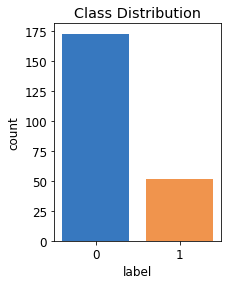

In [78]:
# Distribution of the binary response variable in the analyzed dataset
label_pd = df_user.groupby('label').count().toPandas()

# Plot
plt.rcParams['figure.figsize'] = (3,4)
sns.barplot(x='label', y = 'count', data = label_pd, palette = palette, saturation = 1);
plt.title('Class Distribution');

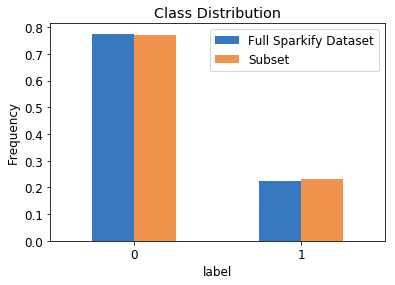

In [79]:
# Similar ratio also on the full Sparkify dataset 
# COPIED FROM notebook used on the CLUSTER:  [5003, 17274]
label_pd['Subset'] = label_pd['count'] / sum(label_pd['count'])
label_pd['count_full'] = [5003, 17274]
label_pd = label_pd.sort_values('label')
label_pd['Full Sparkify Dataset'] = label_pd['count_full'] / sum(label_pd['count_full'])

# Plot
plt.rcParams['figure.figsize'] = (6,4)
label_pd.plot(x='label', y= ['Full Sparkify Dataset', 'Subset'], kind = 'bar', rot = 0, color = [color1, color2]);
plt.ylabel('Frequency');
plt.title('Class Distribution');
plt.savefig('classdist.png')

In [80]:
# Final schema of the transformed dataset
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lastlevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- obsstart: long (nullable = true)
 |-- obsend: long (nullable = true)
 |-- endstate: string (nullable = true)
 |-- nact: long (nullable = false)
 |-- nsongs: long (nullable = true)
 |-- ntbup: long (nullable = true)
 |-- ntbdown: long (nullable = true)
 |-- nfriend: long (nullable = true)
 |-- nplaylist: long (nullable = true)
 |-- ndgrade: long (nullable = true)
 |-- nugrade: long (nullable = true)
 |-- nhome: long (nullable = true)
 |-- nadvert: long (nullable = true)
 |-- nhelp: long (nullable = true)
 |-- nsettings: long (nullable = true)
 |-- nerror: long (nullable = true)
 |-- nact_recent: long (nullable = true)
 |-- nact_oldest: long (nullable = true)
 |-- nsongs_recent: long (nullable = true)
 |-- nsongs_oldest: long (nullable = true)
 |-- obshours: double (nullable = true)
 |-- nact_perh: double (nullable = true)
 |-- nsongs_perh: double (nullable = t

### 3.5 Exploratory Data Analysis
After completing the feature engineering step, we have analyzed the correlations between the built features, and performed also a brief exploratory data analysis to visually compare different statistics between the group of users who churned and the ones who did not.

In [81]:
# For visualization purposes we switch to pandas dataframes
df_user_pd = df_user.toPandas()

#### Feature correlations
As can be clearly seen from the heatmap below there is a high correlation between most of the aggregated activity statistics (per hour). For example, variables ***nact_perh*** and ***nsongs_perh*** are almost perfectly correlated. This is expected, as listening to songs is obviously by far the most common user activity (approx. 80% of all recorded interactions). For the same reason there is a high correlation between ***trend_act*** and ***trend_songs***. In both cases we have decided to simply remove from all further analyses (and the model) both statistics that measure the total activity and keep only variables that measure the most important interaction - playing songs. In order to further reduce the multicolinearity in the data, we have also decided not to use ***nhome_perh*** and ***nplaylist_perh*** in the model. Moreover, ***avgsessionlength*** is highly correlated with average items in each session, thus it can be ignored.

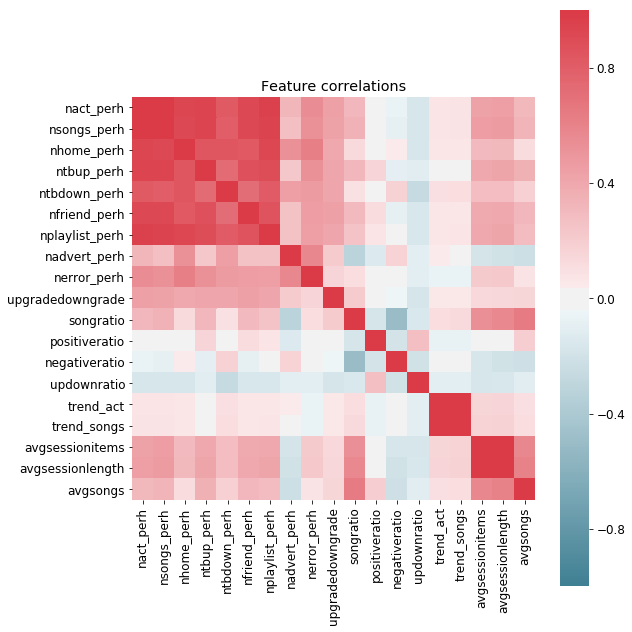

In [82]:
# Calculate correlations between numerical features
cormat = df_user_pd[['nact_perh','nsongs_perh', 'nhome_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_act', 'trend_songs', 'avgsessionitems',  'avgsessionlength','avgsongs']].corr()

# Plot correlations
plt.rcParams['figure.figsize'] = (10,10)
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.heatmap(cormat, cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, vmin = -1, vmax = 1);
plt.title('Feature correlations');
plt.savefig('correlations.png')

#### Exploratory Data Analysis
For each engineered feature (except the ones removed in the step above) we have analyzed its relationship with the binary response variable. This was done by comparing the feature distributions between users who churned and users who kept the service. From the visualizations presented below the following _stylized_ observations have been made:
- on average churned users played more songs per hour;
- churned users gave significantly more thumbs down per hour, and had to watch more advertisements on average;
- the ratio of songs and positive interactions relative to total activity was typically lower for churned users
- churned users had on average less interactions per session
- churn rate is higher for users in the free subscription plan
- churn rate is slightly higher for male users
 
No features have been removed based on this analysis.

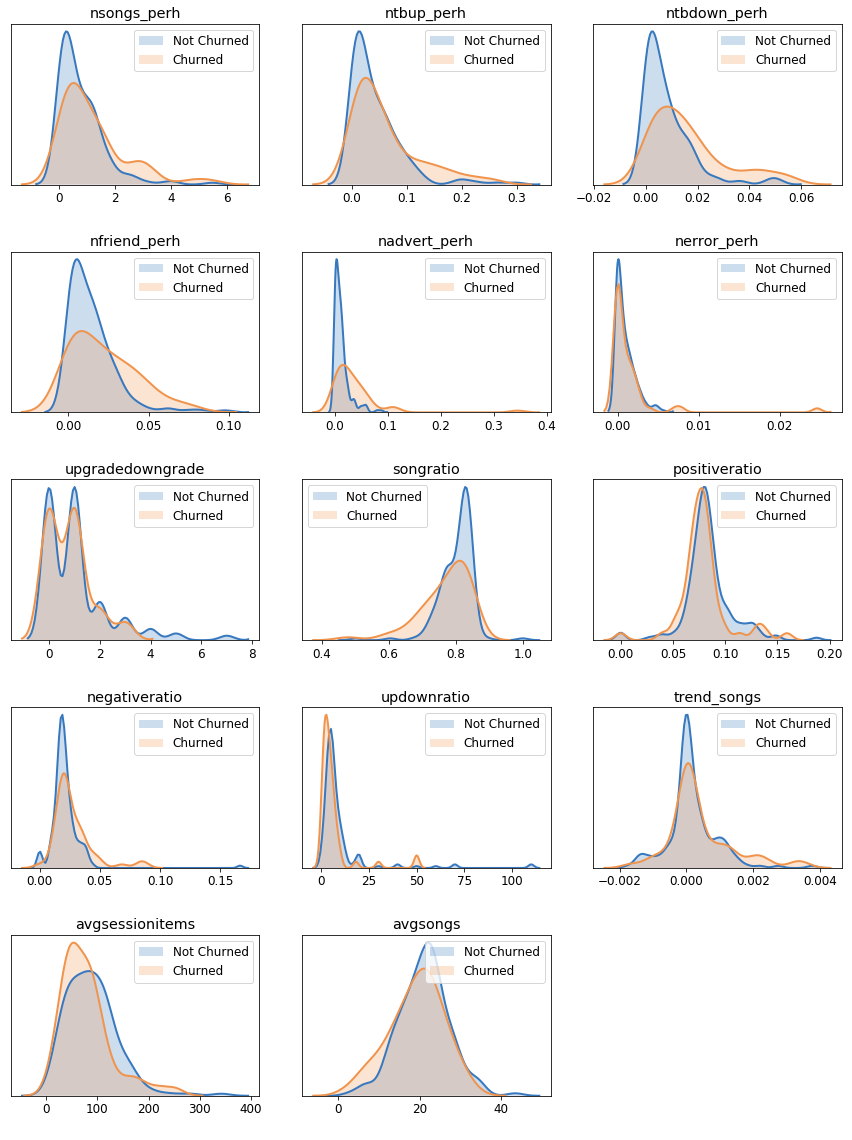

In [83]:
# Plotting the relationship between each numerical feature and binary response

# Numerical features
col = ['nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
       'nfriend_perh', 'nadvert_perh', 'nerror_perh',
       'upgradedowngrade', 'songratio', 'positiveratio',
       'negativeratio', 'updownratio', 'trend_songs', 
       'avgsessionitems','avgsongs']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(col)):
    plt.subplot(5,3,i+1)
    plt.tight_layout();
    sns.distplot(df_user_pd[df_user_pd['label'] == 0][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color1);
    sns.distplot(df_user_pd[df_user_pd['label'] == 1][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color2);
    plt.legend(['Not Churned','Churned']);
    plt.title(col[i]);
    plt.xlabel(" ");
    plt.yticks([]);
    plt.savefig('exploratory.png')

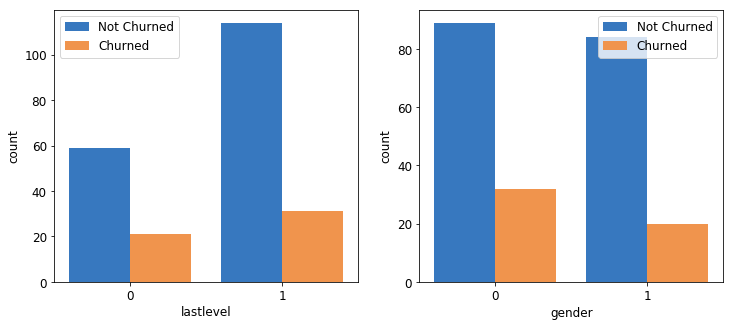

In [84]:
# Analyzing the relationship between categorical features and binary response
# From the visualization we can infer the difference in churn rates between categories of each feature
plt.rcParams['figure.figsize'] = (12,5)

# Last subscription level vs label
plt.subplot(1,2,1)
sns.countplot(x = 'lastlevel', data = df_user_pd, hue = 'label', palette = palette, saturation = 1);
plt.legend(['Not Churned', 'Churned']);

# Gender vs label
plt.subplot(1,2,2)
sns.countplot(x = 'gender', data = df_user_pd, hue = 'label', palette = palette, saturation = 1);
plt.legend(['Not Churned', 'Churned']);

plt.savefig('catexploratory')

## 4. Modeling and Evaluation

We have used Spark's machine learning capabilities to build pipelines that first standardize and combine the engineered features, and then fit one of the Spark-supported binary classifiers. We have performed grid search with cross validation to test several parameter combinations for different classifiers, using the smaller Sparkify dataset in Spark local model. Based on the performance results obtained in cross validation (measured by AUC), we have then selected models with best parameter combinations and retrained them on the entire training set. Ultimately, we have evaluated their performance on the test set, using standard binary classification metrics, such as AUC and F1 score.

Based on the results obtained on the smaller Sparkify dataset, we have selected a subset of good performing models to train and test also on the full 12GB Sparkify dataset, using Amazon's EMR cluster. While training the models on the smaller dataset suffers from a small sample problem (the dataset reduces to 225 users only, 46 in the test set), and can return rather unstable performance results, the full dataset (more than 20k users) allowed us to truly test the efficacy of the developed models. The process has been performed outside this Jupyter notebook, nevertheless, we report all the final results in Section 5 below.

### 4.1 Pipelines

We have first built three different ***Pipeline*** objects for three binary classifiers supported in Spark: **Logistic Regression**, **Random Forest Classifier** and **Gradient-Boosted Tree Classifier**. To recall, the input feature dataset consists of:
- **14 numerical features** (some of the engineered features were removed in the correlation analysis), namely *nsongs_perh*, *ntbup_perh*, *ntbdown_perh*, *nfriend_perh*, *nadvert_perh*, *nerror_perh*, *upgradedowngrade*, *songratio*, *positiveratio*, *negativeratio*, *updownratio*, *trend_songs*, *avgsessionitems*, *avgsongs* (see descriptions in 3.3.)
- **2 binary features**, *lastlevel* and *gender*

Each pipeline combines the following three objects:
1. ***StandardScaler*** that standardizes the numerical features
2. ***VectorAssembler*** that combines them with binary features (already transformed to 0/1 thus no additional transformations are needed)
3. selected **binary classifier** with default parameters (parameters will anyway be passed during grid search)

In [84]:
numeric_columns = ['nsongs_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_songs', 'avgsessionitems','avgsongs']

# Combining multiple numerical features using VectorAssembler
numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

# Standardizing numerical features
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)

# Adding the two binary features
binary_columns = ['lastlevel', 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")

# Defining three different pipelines with three different classifiers, all with default parameters
# Logistic regression 
lr =  LogisticRegression()
pipeline_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, lr])

# Random forest classifier
rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, rf])

# Gradient-boosted tree classifier
gb = GBTClassifier()
pipeline_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, gb])

### 4.2 Grid Search Objects
We have then defined PySpark's grid search objects, namely ***CrossValidator*** objects, that are used to test several parameter combinations for different classifiers, using cross validation. In order to reduce computation times we have only focused on tuning the most prominent parameters of each classifier. The tested parameter values are presented in brackets in the list below.

**a) Logistic Regression**
- ***maxIter*** (maximum number of iterations, default=100) : **[10, 30]**
- ***regParam*** (regularization parameter, default=0.0) : **[0.0, 0.1]**
- ***elasticNetParam*** (mixing parameter - 0 for L2 penalty, 1 for L1 penalty, default=0.0) : **[0.0, 0.5]**

**b) Random Forest Classifier**
- ***maxDepth*** (maximum tree depth, default=5) : **[4, 5, 6, 7]** 
- ***numTrees*** (number of trees, default=20) : **[20, 40]**

**c) Gradient-Boosted Tree Classifier**
- ***maxDepth*** (maximum tree depth, default=5) : **[4, 5]**
- ***maxIter*** (maximum number of iterations, default=20) : **[20, 100]**


In our definition of the grid search objects the performance of each parameter combination is measured by average **AUC** score (area under the ROC) obtained in **4-fold cross validation**. We have chosen AUC since it is a standard binary classification metric that works well for imbalanced datasets. An advantage of using AUC is also that one does not need to worry about optimizing the probability threshold that splits the model outputs into positive and negative predictions, as it summarizes the model performance over all possible thresholds.

**Note**: During the model development we have also implemented the **F1 score** as an alternative custom cross validation evaluator, since in the Spark's built-in evaluator only AUC (area under ROC) and PR AUC (area under precision-recall curve) can be used. We have observed that cross validation with F1 score did not lead to major differences in terms of rankings between tested models, so we have simply worked with the default AUC. Nevertheless, the F1 score evaluator has been used in the final model evaluation on the test set (see Section 4.4).

In [85]:
#Custom F1 score evaluator that we can use instead of BinaryClassificationEvaluator() in grid search
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon to prevent division by zero
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

In [86]:
# Logistic regression grid search

# Parameter combinations
paramGrid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10, 30]) \
.addGrid(lr.regParam, [0.0, 0.1]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5]) \
.build()

# Grid search with cross validation
crossval_lr = CrossValidator(estimator = pipeline_lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [87]:
# Random forest classifier grid search

# Parameter combinations
paramGrid_rf = ParamGridBuilder() \
.addGrid(rf.maxDepth, [4, 5, 6, 7]) \
.addGrid(rf.numTrees, [20, 40]) \
.build()

# Grid search with cross validation
crossval_rf = CrossValidator(estimator = pipeline_rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [88]:
# Gradient-boosted tree classifier grid search

# Parameter combinations
paramGrid_gb = ParamGridBuilder() \
.addGrid(gb.maxDepth, [4, 5]) \
.addGrid(gb.maxIter, [20, 100]) \
.build()

# Grid search with cross validation
crossval_gb = CrossValidator(estimator = pipeline_gb,
                          estimatorParamMaps = paramGrid_gb,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

### 4.3 Training/Test Data Split
The input dataset has been split into training and test set using the **80/20** ratio. During the model tuning the training set is used in 4-fold cross validation so it is further split into multiple training and validation folds.

In [89]:
# Split the data into training (plus validation) and test set 

train_plus_val, test = df_user.randomSplit([0.8, 0.2], seed = 9) 
ntotal = df_user.count()
ntrainval = train_plus_val.count()
ntest = test.count()

print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

Original dataset: 225 rows. Training and validation: 179 rows. Testing set: 46 rows


### 4.4 Model Training and Evaluation

For each defined binary classifier/pipeline we have carried out the following steps:
1. perform grid search with 4-fold cross validation by fitting the defined _CrossValidator_ object on the training data
2. identify the parameter combinations that return the best average AUC in cross validation
3. retrain the best model instance/pipeline on the entire training set
4. if applicable, analyze feature importances
5. evaluate the selected model instance on the test set using both **AUC** and **F1** score metric


#### Performance Metrics

**AUC** is a standard binary classification metric that works well for imbalanced datasets. By using AUC one does not need to worry about where to set the probability threshold that translates the model output probabilities into positive and negative class predictions, since AUC summarizes model's performance over all possible thresholds. This works well in a research environment, but not so much if trying to deploy the model in production, as there needs to be an exact threshold in place to interpret the prediction probabilities.

**F1 score** seems even a better choice for measuring the performance of the implemented binary classifier on a given problem, in which we are working with an imbalanced dataset, and where a strong focus needs to be put on the accurate prediction of the positive class representing churned users. As a music streaming service we want to identify most of the users that are likely to churn (aiming for high recall), but at the same time do not want to give too many discounts and incentives to stay for no reason (aiming for high precision), i.e. to users who are actually happy with the service (false positives), as this can have significant financial implications too. 

#### 4.4.1 Logistic Regression
##### a) Grid-search and Training

In [92]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_lr = crossval_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 2087 seconds


In [94]:
# Store grid search results in a dataframe
scores = crossvalmodel_lr.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC score'] = scores
params_pd

,elasticNetParam,maxIter,regParam,AUC score
0,0.0,10,0.0,0.826223
1,0.5,10,0.0,0.826223
2,0.0,10,0.1,0.784151
3,0.5,10,0.1,0.723698
4,0.0,30,0.0,0.784041
5,0.5,30,0.0,0.784041
6,0.0,30,0.1,0.784151
7,0.5,30,0.1,0.723698


In [95]:
# Retrain the classifier with the best performing parameters
best_lr =  LogisticRegression(maxIter = 10, regParam = 0.0)
pipeline_best_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_lr])

start = time.time()
model_lr = pipeline_best_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 115 seconds


##### b) Evaluation

In [96]:
# Obtain predictions on the test set
results_lr = model_lr.transform(test)
results_lr.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[1.43696490600456...|[0.80798420968711...|       0.0|
|   112|    0|[0.76806937550763...|[0.68310311299456...|       0.0|
|200010|    0|[2.05496957944558...|[0.88644880476549...|       0.0|
|    34|    0|[1.48702842361586...|[0.81563183624568...|       0.0|
|     8|    0|[1.70197234481235...|[0.84579215896250...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [97]:
# AUC score on the test set
auc_evaluator = BinaryClassificationEvaluator()
auc_lr = auc_evaluator.evaluate(results_lr)
print(f'Logistic regression AUC score: {auc_lr}')

Logistic regression AUC score: 0.7412587412587412


In [98]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_lr = f1_evaluator._evaluate(results_lr)
print(f'Logistic regression F1 score: {f1score_lr}')

Logistic regression F1 score: 0.42104786707939895


#### 4.4.2 Random Forest Classifier
##### a) Grid-search and Training

In [99]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_rf = crossval_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 2135 seconds


In [100]:
# Store grid search results in a dataframe
scores = crossvalmodel_rf.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,numTrees,score
0,4,20,0.781959
1,4,40,0.807858
2,5,20,0.761314
3,5,40,0.806842
4,6,20,0.752758
5,6,40,0.797661
6,7,20,0.758198
7,7,40,0.798429


In [101]:
# Retrain the classifier with the best performing parameters
best_rf =  RandomForestClassifier(maxDepth = 4, numTrees = 40)
pipeline_best_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_rf])

start = time.time()
model_rf = pipeline_best_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 181 seconds


In [102]:
# Display feature importances
importances = model_rf.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
9,songratio,0.140960
6,nadvert_perh,0.138116
5,nfriend_perh,0.088227
4,ntbdown_perh,0.085760
14,avgsessionitems,0.081571
2,nsongs_perh,0.073698
12,updownratio,0.068909
8,upgradedowngrade,0.054398
15,avgsongs,0.052772
3,ntbup_perh,0.046600


##### b) Evaluation

In [103]:
# Obtain predictions on the test set
results_rf = model_rf.transform(test)
results_rf.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[35.9445662991030...|[0.89861415747757...|       0.0|
|   112|    0|[34.1069850197360...|[0.85267462549340...|       0.0|
|200010|    0|[29.3991368970919...|[0.73497842242729...|       0.0|
|    34|    0|[34.3587208530212...|[0.85896802132553...|       0.0|
|     8|    0|[36.4243155156607...|[0.91060788789151...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [104]:
# AUC score on the test set
auc_evaluator = BinaryClassificationEvaluator()
auc_rf = auc_evaluator.evaluate(results_rf)
print(f'Random forest classifier AUC score: {auc_rf}')

Random forest classifier AUC score: 0.916083916083916


In [105]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_rf = f1_evaluator._evaluate(results_rf)
print(f'Random forest classifier F1 score: {f1score_rf}')

Random forest classifier F1 score: 0.35293716266364045


#### 4.4.3 Gradient-boosted Tree Classifier
##### a) Grid-search and Training¶

In [106]:
# Perform the grid search by fitting the grid search object
start = time.time()

crossvalmodel_gb = crossval_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 23914 seconds


In [107]:
# Store grid search results in a dataframe
scores = crossvalmodel_gb.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,maxIter,score
0,4,20,0.729123
1,4,100,0.747087
2,5,20,0.762869
3,5,100,0.763980


In [108]:
# Retrain the classifier with the best performing parameters
best_gb =  GBTClassifier(maxDepth = 5, maxIter = 100)
pipeline_best_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_gb])

start = time.time()
model_gb = pipeline_best_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 2348 seconds


In [109]:
# Display feature importances
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
6,nadvert_perh,0.202165
5,nfriend_perh,0.157936
9,songratio,0.100771
4,ntbdown_perh,0.088578
15,avgsongs,0.063245
2,nsongs_perh,0.058957
13,trend_songs,0.057869
7,nerror_perh,0.047756
11,negativeratio,0.041446
8,upgradedowngrade,0.041262


##### b) Evaluation

In [110]:
# Obtain predictions on the test set
results_gb = model_gb.transform(test)
results_gb.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[2.08575414019154...|[0.98480546469933...|       0.0|
|   112|    0|[0.11229648380503...|[0.55591340724444...|       0.0|
|200010|    0|[-0.7790162335730...|[0.17392915648420...|       1.0|
|    34|    0|[1.65767306332366...|[0.96495153727642...|       0.0|
|     8|    0|[2.20901481320448...|[0.98808569471282...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [111]:
# AUC score on the test set
auc_evaluator = BinaryClassificationEvaluator()
auc_gb = auc_evaluator.evaluate(results_gb)
print(f'Gradient-boosted tree classifier AUC score: {auc_gb}')

Gradient-boosted tree classifier AUC score: 0.8298368298368297


In [112]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_gb = f1_evaluator._evaluate(results_gb)
print(f'Gradient-boosted tree classifier F1 score: {f1score_gb}')

Gradient-boosted tree classifier F1 score: 0.5454492149190361


### 4.5. Results Summary

We have ultimately trained and tested three different models, one per each classifier type. The results obtained on the test set are summarized in the table below.

|Classifier                        | Parameters              |  AUC  |  F1   |
| :------------------------------- | :---------------------- |-------|-------|
|Logistic Regression               | maxIter=10, regParam=0  | 0.741 | 0.421 |
|Random Forest Classifier          | maxDepth=4, numTrees=40 | 0.916 | 0.353 |
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=100 | 0.830 | 0.545 |

The AUC is relatively high for all three model, particularly for the Random Forest Classifier, but also for the Gradient-boosted Tree Classifier. The F1 scores show a significantly weaker performance, with only the gradient boosting approach scoring a solid 0.545. However, since the AUC scores are high it is very likely that we could substantially increase the F1 score on the test set by optimizing the probability threshold that splits positive and negative class predictions. The above F1 scores have been obtained using the default 0.5 threshold.

We have to emphasize that these results correspond to models that were trained and tested using the **smaller Sparkify dataset** that in total consists of only 225 unique users. This means the models are tested on a sample with 46 instances, out of which only around 10 are positive classes (on average), and this leads to rather unstable performance evaluation results.

Instead of attempting to further optimize the model performance on the smaller dataset, we have focused on the most important part of the project, training and testing the selected churn prediction models on the full Sparkify dataset. The final results are presented in Section 5 below.

## 5. Training and testing on the full Sparkify dataset

After finalizing the model development process on the small Sparkify subset we have reused the developed implementations also on the **full Sparkify dataset**. The dataset is too big to be processed locally and therefore an Elastic MapReduce (EMR) cluster has been deployed on the AWS cloud to carry out the tasks. Due to budget constraints, and consequently also computational constraints, we could not perform the full scale grid search for all the chosen binary classifiers. Therefore, we have simply selected a subset of models that performed well on the smaller dataset, and for which we think they have potential of doing so also on the larger dataset. Based on the solid performance in terms of both AUC and F1 metrics on the small dataset, we have decided to use different instances of the **Gradient-Boosted Tree Classifier**. The ensemble method typically performs better than simpler classifiers, e.g. logistic regression. In terms of parameters we have used the default maximum tree depth of 5 for all instances, but gradually increased the parameter that controls the maximum number of gradient boosting iterations. The final results achieved on the test set (the analysis is performed outside this notebook) are presented in the table below.

|Classifier                        | Parameters              |  AUC  |  F1   |
| :------------------------------- |-------------------------|-------|-------|
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=20  | 0.941 | 0.733 |
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=100 | 0.971 | 0.816 |
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=200 | 0.981 | 0.855 |

With more training data provided to the classifier the results are clearly much better than the ones achieved on the smaller dataset. It can also be seen that both AUC and F1 score improve with higher number of maximum gradient boosting iterations. The best performing model has AUC score of 0.981 and F1 score higher than 0.85. 

Based on the very positive outcome we can conclude that we have managed to build a binary classifier which can accurately identify users who cancelled the music streaming service, based on the features that capture insights of users' past activity and interaction with the service. If deployed, the trained model could be used to identify users at risk of churning in advance, and help the music streaming business prevent severe financial losses.

#### Feature Importances

With the above we have confirmed that the chosen gradient boosting classifier performs well, but have not clarified yet why exactly it performs well. This can be done by extracting feature importances from the trained model object, and analyzing which ones contribute the most to the accurate model predictions.

As seen in the visualization below, the most important feature for identifying churned users is the ***nerror_perh*** which measures how many error pages have been shown to the user per hour. Intuitively, the more errors a user has to experience the more likely it is that he/she is dissatisfied with the service. Similar holds also for the second and third most important feature, ***ntbdown_perh*** and ***nadvert_perh*** which measure the number of thumbs down given per hour and number of advertisements seen per hour, respectively. Despite all the extra calculations, it was worth including in the feature set also the 4th most important ***trend_songs*** variable which measures user's song listening activity trend. 

The two binary features, namely ***lastlevel*** (i.e. the last known subscription level) and ***gender***, do not contribute much to predicting churned users.

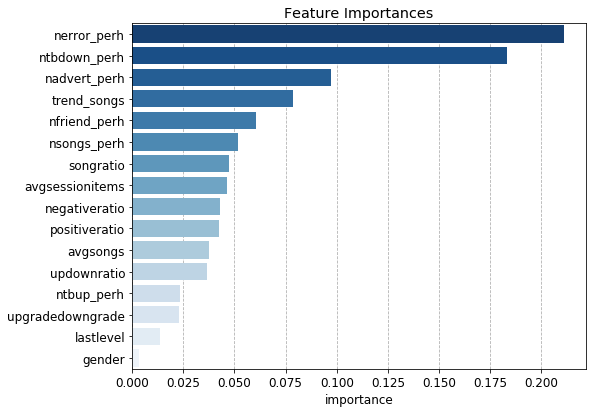

In [77]:
# Data copied from the notebook that was run on an EMR cluster
features = ['lastlevel', 'gender', 'nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
            'nfriend_perh', 'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 
            'songratio', 'positiveratio', 'negativeratio', 'updownratio', 
            'trend_songs', 'avgsessionitems', 'avgsongs']
importances = [0.013795342305289867, 0.003419130795754195, 0.05192724418392687, 
               0.023604481206826188, 0.18329355168409747, 0.060501586172062846, 0.0974098898402886,
               0.2110401549499677, 0.02286163968506689, 0.04730318423769473, 0.04232860002653574, 
               0.043054343894025765, 0.036773157537074976, 0.07858267078570629, 0.046534988450475566, 0.03757003424520641]
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# Plot
plt.rcParams['figure.figsize'] = (9,6)
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.barplot(data = feat_imp_pd, y = "feature", x ="importance",
           palette = 'Blues_r', zorder=2);
plt.grid(axis = 'x', linestyle = '--', zorder=0)
plt.title("Feature Importances")
plt.ylabel("");
plt.savefig('feature.png')

## 6. Conclusions

### Reflection 
Based on the good performance of the developed models (as presented in Section 5) we can conclude that we have managed to build a binary classifier that can accurately identify churned users, based on the patterns in past user activity and interaction with the music streaming service. If deployed, the trained model could be used to identify users at risk of churning in advance, and help the music streaming business prevent severe financial losses.

The most challenging and also most interesting part of the project was the feature engineering part, as it requires good intuition and quite some creativity. One needs to come up with features that contain key insights for identifying users who churned, but at the same time be careful not to build predictor variables that contain information that would not be available if running a model on an unlabelled dataset (further discussion is available in Section 3.3).


### Potential Improvements

Despite the good performance of the developed model there is still room for further improvements:
- build and test features that capture additional insights about user's activity patterns, e.g. average length of song listening sessions, ratios of skipped or partially listened songs, etc.
- utilize song-level features that have been ignored so far, e.g. calculate the user's listening diversity in terms of different songs/artists listened to in the specified observation period, etc.
- optimize data wrangling and feature engineering steps by using Spark's best practices in order to speed up model training and testing (current solution is rather slow and does not scale well)
- perform comprehensive grid search for the gradient boosting model on the full Sparkify dataset, using the EMR cluster
